**Social Networks and Recommendation Systems Project 12**

*Salveen Singh Dutt*

*Patryk Prusak*

Created with a bit of help from GitHub Copilot

In [108]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import ast
from datetime import datetime
import seaborn as sns
from collections import Counter
from textblob import TextBlob
import gc
import geopandas as gpd

### Functions

In [109]:
def load_twitter_users(url):
    return pd.read_csv(url)


def categorize_sentiment(score):
    if score > 0.1:
        return "positive"
    elif score < -0.1:
        return "negative"
    else:
        return "neutral"


def load_twitter_data(url):
    """
    Load Twitter data with proper parsing of list fields
    """
    try:
        df = pd.read_csv(url)
        # Convert string representations of lists to actual lists
        df["hashtags"] = df["hashtags"].apply(ast.literal_eval)
        df["mentions"] = df["mentions"].apply(ast.literal_eval)
        df["expanded_urls"] = df["expanded_urls"].apply(ast.literal_eval)
        print(f"Loaded {len(df)} tweets")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None


def user_behavior_analysis(df):
    user_activity = df.groupby("user_id").size().sort_values(ascending=False)
    df["created_at"] = pd.to_datetime(df["created_at"], unit="ms")

    df["date"] = df["created_at"].dt.date
    df["hour"] = df["created_at"].dt.hour
    df["day_of_week"] = df["created_at"].dt.day_name()
    df["month"] = df["created_at"].dt.month
    df["year"] = df["created_at"].dt.year
    return user_activity


def content_analysis(df):
    hashtag_counts = Counter([tag for tags in df["hashtags"] for tag in tags])
    df["sentiment"] = (
        df["text"].fillna("").apply(lambda x: TextBlob(x).sentiment.polarity)
    )
    return hashtag_counts


def create_interaction_network(df):
    """
    Create a network based on mentions, retweets, and replies
    """
    G = nx.DiGraph()

    for _, row in df.iterrows():
        source_user = row["user_key"]

        if not G.has_node(source_user):
            G.add_node(source_user)

        for mentioned_user in row["mentions"]:
            if not G.has_node(mentioned_user):
                G.add_node(mentioned_user)
            G.add_edge(source_user, mentioned_user, type="mention")

        if (
            pd.notna(row["in_reply_to_status_id"])
            and row["in_reply_to_status_id"] != ""
        ):
            reply_to = df[df["tweet_id"] == row["in_reply_to_status_id"]][
                "user_key"
            ].values
            if len(reply_to) > 0:
                if not G.has_node(reply_to[0]):
                    G.add_node(reply_to[0])
                G.add_edge(source_user, reply_to[0], type="reply")

        if pd.notna(row["retweeted_status_id"]) and row["retweeted_status_id"] != "":
            retweeted = df[df["tweet_id"] == row["retweeted_status_id"]][
                "user_key"
            ].values
            if len(retweeted) > 0:
                if not G.has_node(retweeted[0]):
                    G.add_node(retweeted[0])
                G.add_edge(source_user, retweeted[0], type="retweet")

    return G


def analyze_network(G):
    """
    Perform network analysis and return key metrics
    """
    metrics = {
        "num_nodes": G.number_of_nodes(),
        "num_edges": G.number_of_edges(),
        "density": nx.density(G),
        "avg_degree": sum(dict(G.degree()).values()) / G.number_of_nodes(),
    }

    metrics["degree_cent"] = nx.degree_centrality(G)
    metrics["in_degree_cent"] = nx.in_degree_centrality(G)
    metrics["out_degree_cent"] = nx.out_degree_centrality(G)

    metrics["top_influential"] = sorted(
        metrics["degree_cent"].items(), key=lambda x: x[1], reverse=True
    )[:10]
    metrics["top_mentioned"] = sorted(
        metrics["in_degree_cent"].items(), key=lambda x: x[1], reverse=True
    )[:10]
    metrics["top_active"] = sorted(
        metrics["out_degree_cent"].items(), key=lambda x: x[1], reverse=True
    )[:10]

    return metrics


def visualize_network(G, metrics, title="Twitter Interaction Network"):
    """
    Create and save network visualization with different edge colors for different types
    """
    plt.figure(figsize=(15, 10))

    pos = nx.spring_layout(G, k=1.5, iterations=50)

    node_sizes = [3000 * metrics["degree_cent"][node] for node in G.nodes()]
    nx.draw_networkx_nodes(
        G, pos, node_color="lightblue", node_size=node_sizes, alpha=0.7
    )

    edge_colors = {"mention": "blue", "reply": "green", "retweet": "red"}

    for edge_type, color in edge_colors.items():
        edges = [
            (u, v) for (u, v, d) in G.edges(data=True) if d.get("type") == edge_type
        ]
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=edges,
            edge_color=color,
            alpha=0.4,
            arrows=True,
            arrowsize=10,
        )

    plt.plot([], [], "b-", label="Mention")
    plt.plot([], [], "g-", label="Reply")
    plt.plot([], [], "r-", label="Retweet")
    plt.legend()

    plt.title(title)
    plt.axis("off")
    plt.savefig("twitter_network.png", dpi=300, bbox_inches="tight")
    plt.close()


def analyze_tweet_patterns(df):
    """
    Analyze patterns in the tweet dataset
    """
    patterns = {
        "total_tweets": len(df),
        "unique_users": df["user_key"].nunique(),
        "hashtag_stats": {},
        "temporal_patterns": {},
    }

    all_hashtags = [tag for tags in df["hashtags"] for tag in tags]
    patterns["hashtag_stats"] = {
        "total_hashtags": len(all_hashtags),
        "unique_hashtags": len(set(all_hashtags)),
        "top_hashtags": pd.Series(all_hashtags).value_counts().head(10).to_dict(),
    }

    df["created_at"] = pd.to_datetime(df["created_str"])
    patterns["temporal_patterns"] = {
        "tweets_by_hour": df.groupby(df["created_at"].dt.hour).size().to_dict(),
        "tweets_by_day": df.groupby(df["created_at"].dt.dayofweek).size().to_dict(),
    }

    return patterns


def generate_report(df, metrics, patterns):
    """
    Generate comprehensive analysis report
    """
    report = f"""
Twitter Network Analysis Report
=============================

Network Statistics:
-----------------
• Total Users in Network: {metrics['num_nodes']:,}
• Total Interactions: {metrics['num_edges']:,}
• Network Density: {metrics['density']:.4f}
• Average Interactions per User: {metrics['avg_degree']:.2f}

Top Influential Users (by Total Interactions):
------------------------------------------
"""
    for user, score in metrics["top_influential"]:
        report += f"• {user}: {score:.4f}\n"

    report += "\nMost Mentioned Users:\n"
    for user, score in metrics["top_mentioned"]:
        report += f"• {user}: {score:.4f}\n"

    report += "\nMost Active Users:\n"
    for user, score in metrics["top_active"]:
        report += f"• {user}: {score:.4f}\n"

    report += "\nHashtag Analysis:\n"
    report += (
        f"• Total Hashtags Used: {patterns['hashtag_stats']['total_hashtags']:,}\n"
    )
    report += f"• Unique Hashtags: {patterns['hashtag_stats']['unique_hashtags']:,}\n"
    report += "\nTop Hashtags:\n"
    for hashtag, count in patterns["hashtag_stats"]["top_hashtags"].items():
        report += f"• #{hashtag}: {count:,} uses\n"

    return report

### Load tweet data

In [110]:
url = "https://nodeassets.nbcnews.com/russian-twitter-trolls/tweets.csv"

df = load_twitter_data(url)

Loaded 203451 tweets


### User behaviour analysis

In [111]:
user_activity = user_behavior_analysis(df)

#### Most active users

In [112]:
user_activity.head(5).to_csv("figures/user_activity.csv")
user_activity.head(5)

user_id
1.679279e+09    9269
1.671235e+09    6813
2.882014e+09    6652
2.671070e+09    4140
4.508631e+09    3663
dtype: int64

#### Daily, Monthly etc. activity analysis

In [113]:
daily_activity = df.groupby("date").size()

weekly_activity = df.resample("W", on="created_at").size()

monthly_activity = df.resample("M", on="created_at").size()

C:\Users\patrykprusak\AppData\Local\Temp\ipykernel_43144\315785024.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_activity = df.resample("M", on="created_at").size()


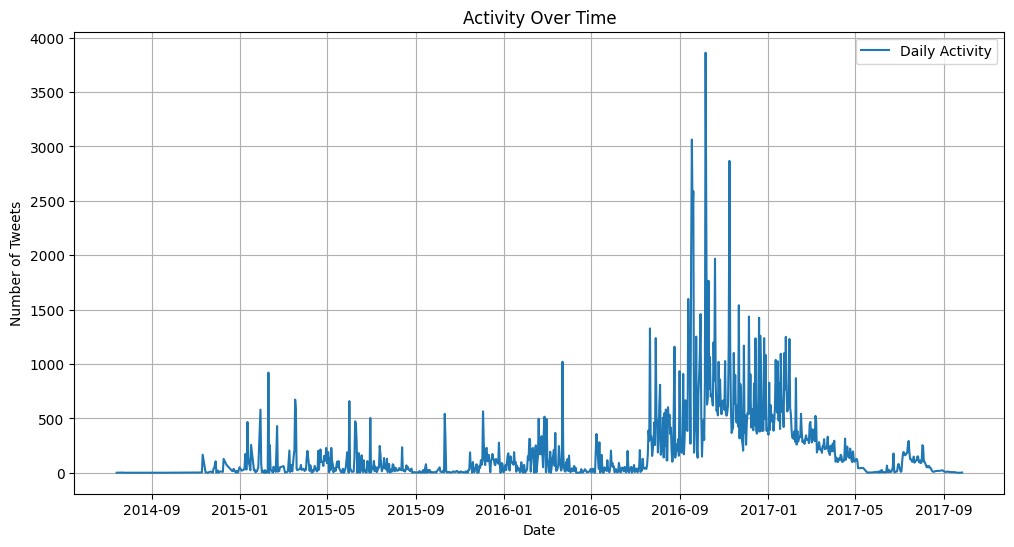

In [114]:
plt.figure(figsize=(12, 6))
plt.plot(daily_activity.index, daily_activity.values, label="Daily Activity")
plt.title("Activity Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.legend()
plt.grid(True)
plt.savefig("figures/activity_over_time.png")
plt.show()

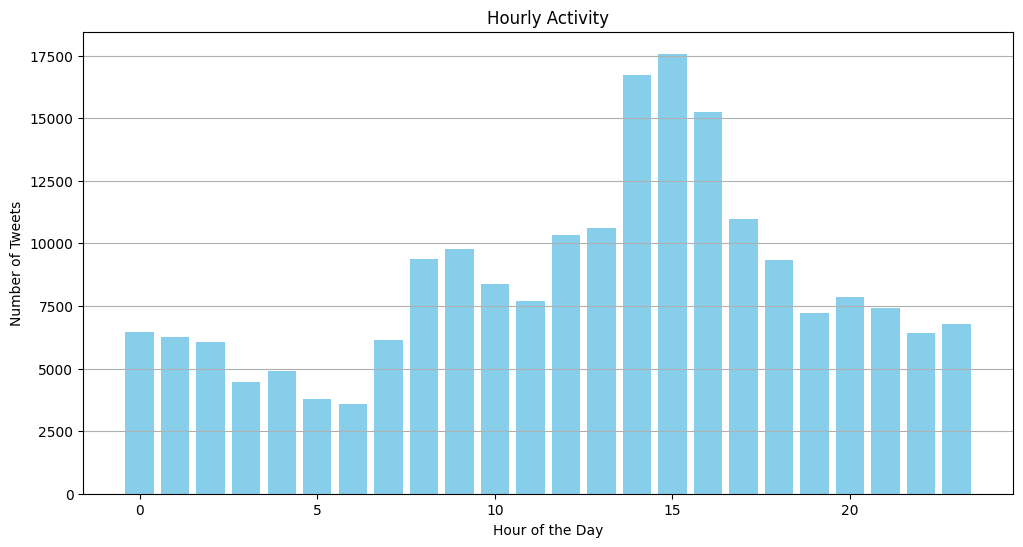

In [115]:
hourly_activity = df.groupby("hour").size()

plt.figure(figsize=(12, 6))
plt.bar(hourly_activity.index, hourly_activity.values, color="skyblue")
plt.title("Hourly Activity")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Tweets")
plt.grid(axis="y")
plt.savefig("figures/hourly_activity.png")
plt.show()

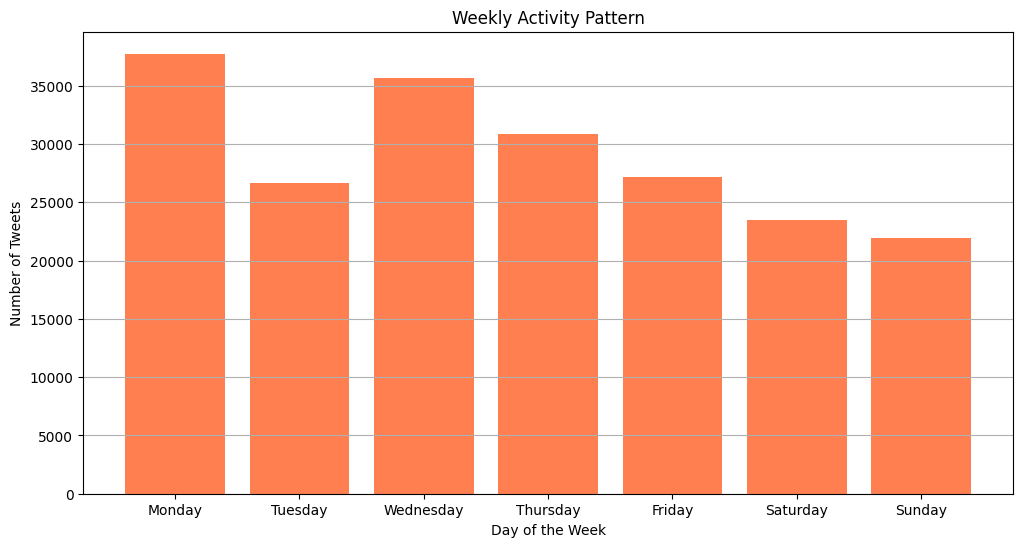

In [116]:
weekly_pattern = (
    df.groupby("day_of_week")
    .size()
    .reindex(
        ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    )
)

plt.figure(figsize=(12, 6))
plt.bar(weekly_pattern.index, weekly_pattern.values, color="coral")
plt.title("Weekly Activity Pattern")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Tweets")
plt.grid(axis="y")
plt.savefig("figures/weekly_activity.png")
plt.show()

In [117]:
threshold = daily_activity.mean() + 3 * daily_activity.std()
anomalies = daily_activity[daily_activity > threshold]

print("Anomalies in activity:")
anomalies.to_csv("figures/anomalies_in_activity.csv", index=True)
print(anomalies)

Anomalies in activity:
date
2016-07-21    1327
2016-09-12    1598
2016-09-16    1992
2016-09-17    3063
2016-09-18    2367
2016-09-19    2587
2016-09-29    1459
2016-10-06    3861
2016-10-07    2221
2016-10-10    1765
2016-10-19    1968
2016-11-08    2867
2016-11-21    1540
2016-12-05    1437
2016-12-19    1425
dtype: int64


### Content analysis

In [118]:
hashtag_counts = content_analysis(df)

#### Hashtags

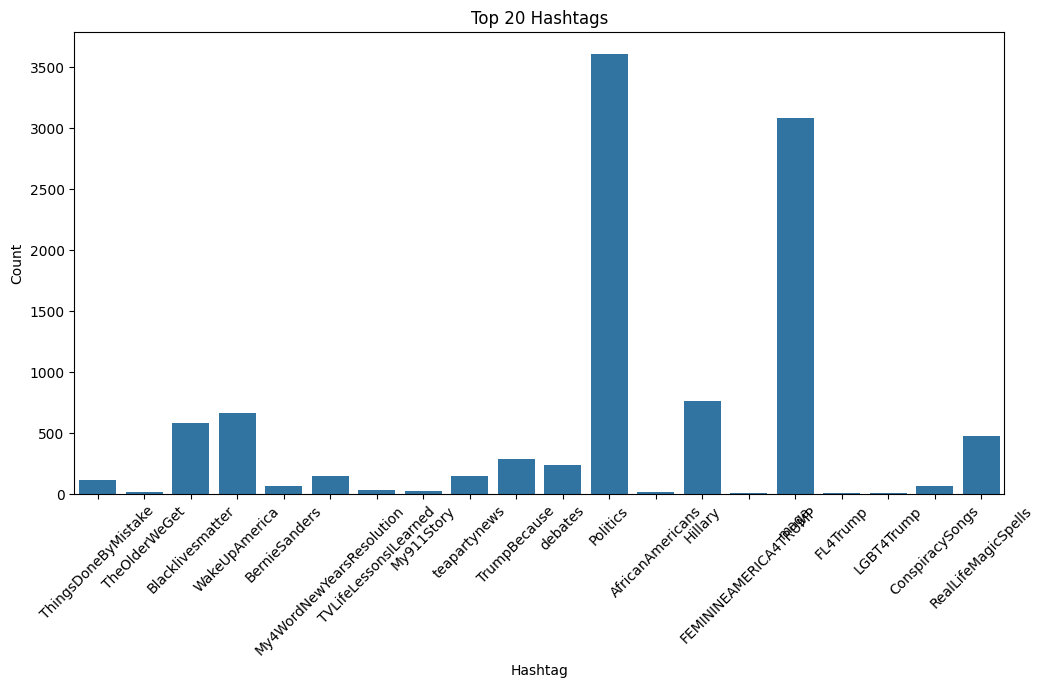

In [119]:
hashtags_df = pd.DataFrame(hashtag_counts.items(), columns=["hashtag", "count"])
plt.figure(figsize=(12, 6))
sns.barplot(x="hashtag", y="count", data=hashtags_df.head(20))
plt.title("Top 20 Hashtags")
plt.xlabel("Hashtag")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.savefig("figures/top_hashtags.png")
plt.show()

#### Sentiment analysis

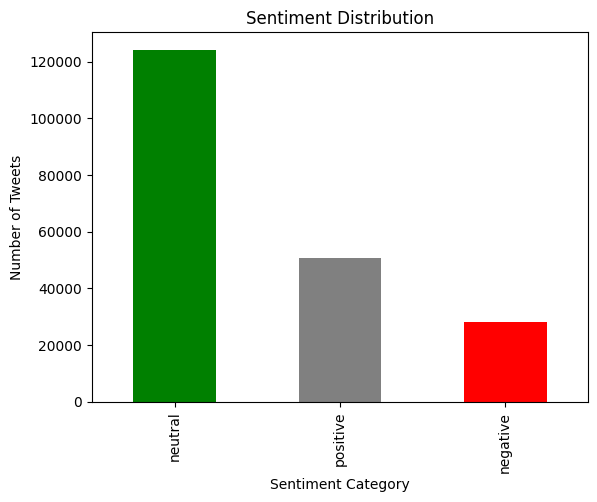

In [120]:
df["sentiment_category"] = df["sentiment"].apply(categorize_sentiment)
df["sentiment_category"].value_counts().plot(kind="bar", color=["green", "gray", "red"])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Tweets")
plt.savefig("figures/sentiment_distribution.png")
plt.show()

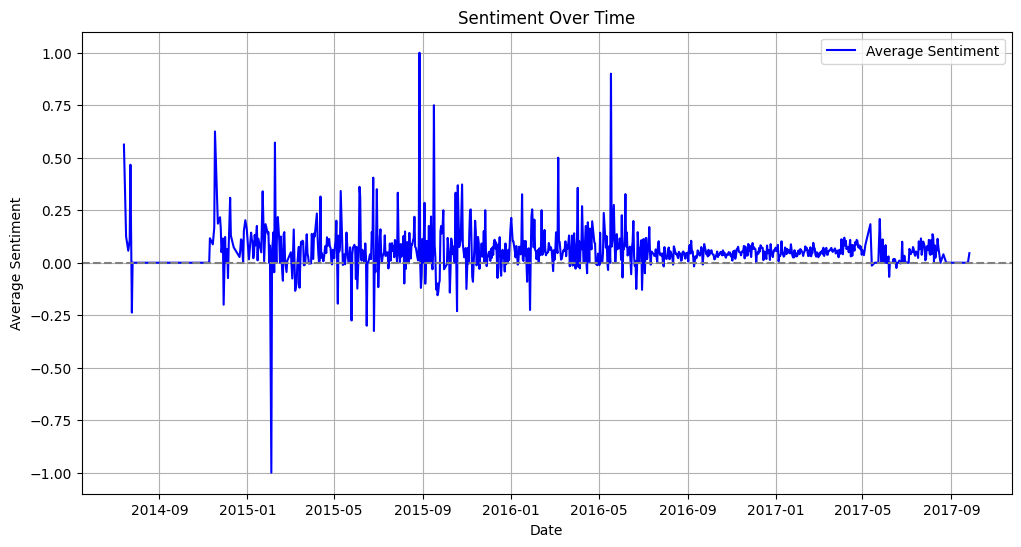

In [121]:
df["created_at"] = pd.to_datetime(df["created_at"], unit="ms")
sentiment_over_time = df.groupby(df["created_at"].dt.date)["sentiment"].mean()

plt.figure(figsize=(12, 6))
plt.plot(
    sentiment_over_time.index,
    sentiment_over_time.values,
    label="Average Sentiment",
    color="blue",
)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Sentiment Over Time")
plt.xlabel("Date")
plt.ylabel("Average Sentiment")
plt.legend()
plt.grid(True)
plt.savefig("figures/sentiment_over_time.png")
plt.show()

In [122]:
hashtag_sentiment = df.explode("hashtags").groupby("hashtags")["sentiment"].mean()

top_positive_hashtags = hashtag_sentiment.sort_values(ascending=False).head(10)

top_negative_hashtags = hashtag_sentiment.sort_values().head(10)

print("Top Positive Hashtags:")
print(top_positive_hashtags)
top_positive_hashtags.to_csv("figures/top_positive_hashtags.csv", header=True)
print("\nTop Negative Hashtags:")
top_negative_hashtags.to_csv("figures/top_negative_hashtags.csv", header=True)
print(top_negative_hashtags)

Top Positive Hashtags:
hashtags
SignsYouAreOnTheRightPath    1.0
rt171                        1.0
NiceTry                      1.0
artwork                      1.0
PrinceRIP                    1.0
relationships                1.0
ThoughtsBeforeBed            1.0
DeplorablesChallenge         1.0
WennFraktionskollegen        1.0
HappyTaeminDay               1.0
Name: sentiment, dtype: float64

Top Negative Hashtags:
hashtags
youreawaste      -1.0
237              -1.0
riot             -1.0
ObamaHillary     -1.0
NoneOfTheAbove   -1.0
Not1More         -1.0
DeflectLies      -1.0
FedUp            -1.0
AmberAmour       -1.0
demons           -1.0
Name: sentiment, dtype: float64


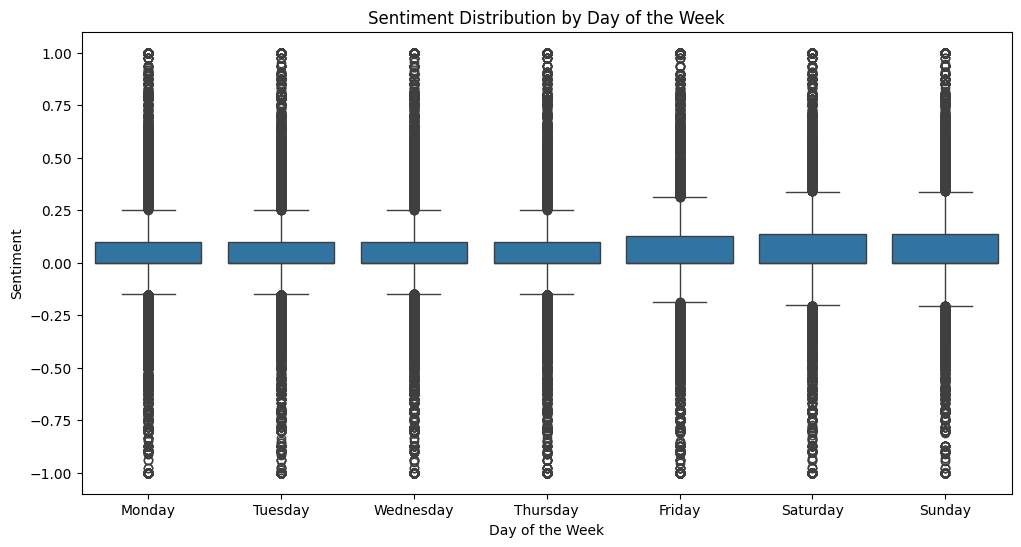

In [123]:
df["day_of_week"] = df["created_at"].dt.day_name()

plt.figure(figsize=(12, 6))
sns.boxplot(
    x="day_of_week",
    y="sentiment",
    data=df,
    order=[
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ],
)
plt.title("Sentiment Distribution by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Sentiment")
plt.savefig("figures/sentiment_by_day.png")
plt.show()

### Most influential users

In [124]:
edges = df[["user_id", "retweeted_status_id"]].dropna()

retweet_graph = nx.DiGraph()
retweet_graph.add_edges_from(edges.values)

print(f"Number of nodes: {retweet_graph.number_of_nodes()}")
print(f"Number of edges: {retweet_graph.number_of_edges()}")

# Find most influential users (PageRank)
pagerank = nx.pagerank(retweet_graph)
top_influencers = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Influencers by PageRank:")
print(top_influencers)
top_influencers_df = pd.DataFrame(
    top_influencers, columns=["user_id", "pagerank"]
).to_csv("figures/top_influencers.csv", index=False)

Number of nodes: 32638
Number of edges: 39032
Top Influencers by PageRank:
[(np.float64(7.961432299052892e+17), 0.0003112233542326999), (np.float64(2.8081206453928346e+17), 0.00023092329499704416), (np.float64(7.995045265333371e+17), 0.0002135611200271726), (np.float64(7.948432242044068e+17), 0.0001158988858216453), (np.float64(7.592193446268109e+17), 0.0001085199614594499), (np.float64(7.855621558317548e+17), 0.00010070698272300774), (np.float64(7.556564785440317e+17), 8.247669900464263e-05), (np.float64(7.63679159273005e+17), 8.247669900464263e-05), (np.float64(7.859281935008604e+17), 5.6433436549835364e-05), (np.float64(7.636247596365332e+17), 5.6433436549835364e-05)]


### Network Analysis

In [125]:
G = nx.DiGraph()
for _, row in df.iterrows():
    if row["mentions"]:
        for mention in row["mentions"]:
            G.add_edge(row["user_key"], mention)

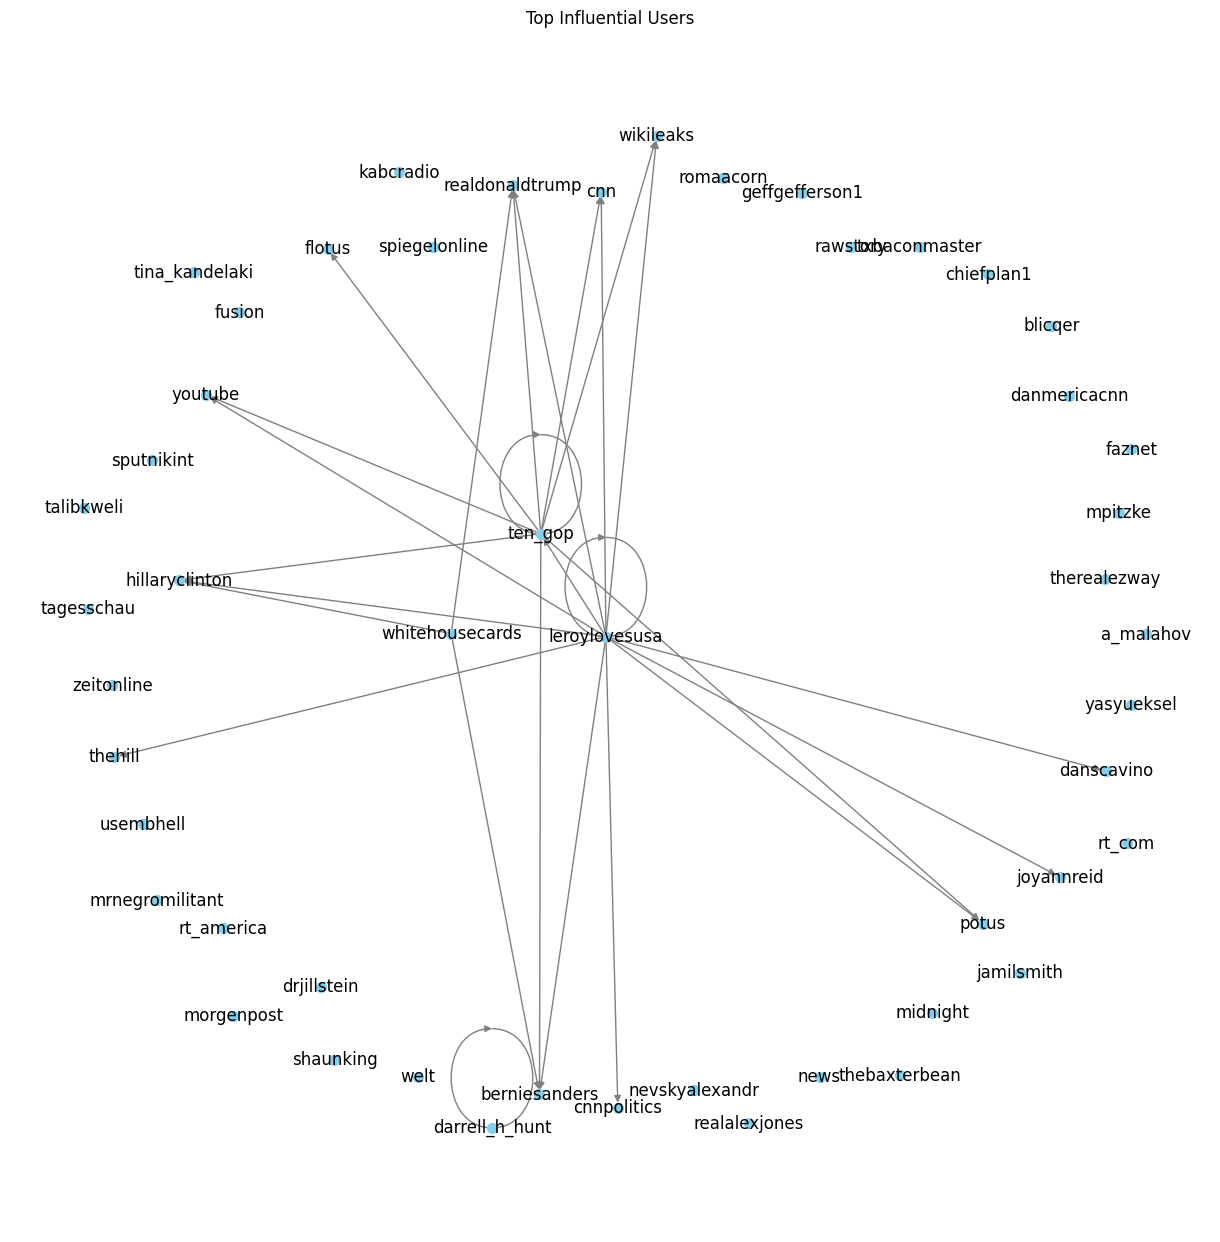

In [126]:
pagerank = nx.pagerank(G)
top_pagerank_nodes = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[
    :50
]  # Top 50 nodes

top_nodes = [node for node, _ in top_pagerank_nodes]
influential_graph = G.subgraph(top_nodes)

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(influential_graph, k=0.1)
nx.draw(
    influential_graph,
    pos,
    with_labels=True,
    node_size=50,
    node_color="skyblue",
    font_size=12,
    font_color="black",
    edge_color="gray",
)
plt.title("Top Influential Users")
plt.savefig("figures/top_influential_users.png")
plt.show()

### Bots

In [127]:
df_sorted = df.sort_values(by=["user_key", "created_at"])

df_sorted["time_diff"] = (
    df_sorted.groupby("user_key")["created_at"].diff().dt.total_seconds()
)

df_intervals = df_sorted.dropna(subset=["time_diff"])

short_intervals = df_intervals[df_intervals["time_diff"] < 60]

short_intervals_summary = (
    short_intervals.groupby("user_key")
    .agg(
        {
            "time_diff": ["mean", "min", "max", "count"],
            "user_id": "first",
            "created_at": ["min", "max"],
        }
    )
    .reset_index()
)

short_intervals_summary.columns = [
    "user_key",
    "mean_interval",
    "min_interval",
    "max_interval",
    "tweet_count",
    "user_id",
    "first_tweet",
    "last_tweet",
]

short_intervals_summary = short_intervals_summary.sort_values(by="mean_interval")
short_intervals_summary[short_intervals_summary["tweet_count"] > 10].head(10).to_csv(
    "figures/short_intervals_summary.csv", index=False
)
short_intervals_summary[short_intervals_summary["tweet_count"] > 10].head(10)

,user_key,mean_interval,min_interval,max_interval,tweet_count,user_id,first_tweet,last_tweet
189,newarkvoice,1.136986,0.0,5.0,73,3.091936e+09,2016-08-17 11:32:17,2016-10-03 12:20:41
275,worldnewspoli,3.916667,1.0,11.0,24,7.892661e+17,2016-10-28 02:01:15,2016-11-08 12:32:45
38,brianaregland,5.233398,3.0,54.0,2575,1.868496e+09,2016-07-19 16:37:39,2017-01-16 12:11:41
204,paulinett,5.669854,0.0,56.0,2196,1.617939e+09,2016-08-23 13:44:22,2017-07-27 22:46:34
165,lilylilyhasse,6.023256,2.0,33.0,43,NaN,2017-06-14 16:26:49,2017-06-30 14:39:52
242,staywoke88,6.068182,4.0,14.0,44,1.651693e+09,2016-10-07 04:58:20,2016-11-21 04:15:30
192,nojonathonno,6.518519,4.0,59.0,54,1.518857e+09,2016-07-23 17:23:47,2016-11-21 06:55:16
75,datwisenigga,6.795031,4.0,59.0,2093,1.684524e+09,2016-07-23 15:28:55,2017-08-07 17:29:32
176,melanymelanin,6.843947,0.0,59.0,1743,1.655194e+09,2016-01-07 20:33:52,2017-01-30 18:28:21
160,laurabaeley,7.049107,0.0,59.0,2464,1.658203e+09,2015-06-01 23:30:41,2017-03-24 11:23:46


#### Main graph and report

In [ ]:
G = create_interaction_network(df)
metrics = analyze_network(G)
patterns = analyze_tweet_patterns(df)

visualize_network(G, metrics)

report = generate_report(df, metrics, patterns)

with open("twitter_analysis_report.txt", "w") as f:
    f.write(report)

### Users

In [129]:
gc.collect()

15492

In [130]:
df_users = load_twitter_users(
    "https://nodeassets.nbcnews.com/russian-twitter-trolls/users.csv"
)

In [131]:
df_users.columns

Index(['id', 'location', 'name', 'followers_count', 'statuses_count',
       'time_zone', 'verified', 'lang', 'screen_name', 'description',
       'created_at', 'favourites_count', 'friends_count', 'listed_count'],
      dtype='object')

#### Influential users

In [132]:
df_users["influence_score"] = df_users["followers_count"] + df_users["friends_count"]
top_influencers = df_users.sort_values(by="influence_score", ascending=False).head(10)
top_influencers.to_csv("figures/top_influential_users.csv", index=False)
print("Top Influential Users:")
print(
    top_influencers[
        ["screen_name", "followers_count", "friends_count", "influence_score"]
    ]
)

Top Influential Users:
        screen_name  followers_count  friends_count  influence_score
314    MaxDementiev          98412.0           94.0          98506.0
3     KadirovRussia          94773.0            7.0          94780.0
190     Jenn_Abrams          61609.0        20600.0          82209.0
184     TodayNYCity          60897.0         5999.0          66896.0
151      Politweecs          32846.0        25600.0          58446.0
334     PigeonToday          29524.0        21248.0          50772.0
266    coldwar20_ru          44470.0         5300.0          49770.0
178    LavrovMuesli          47080.0         2356.0          49436.0
188     GiselleEvns          24344.0        21953.0          46297.0
183  WashingtOnline          31729.0        12148.0          43877.0


#### Top locations

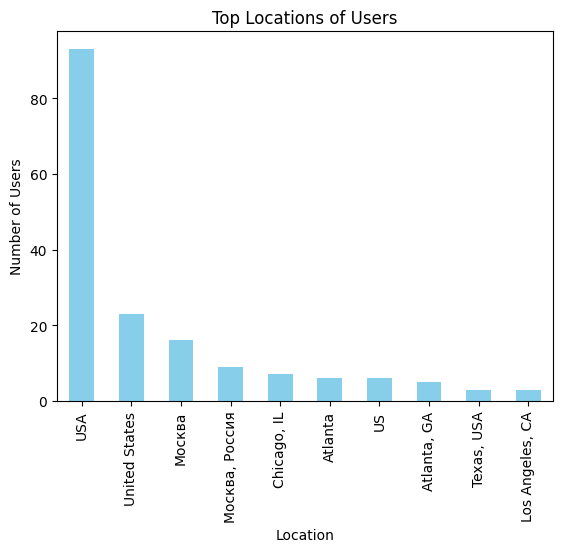

In [133]:
users_with_location = df_users[df_users["location"].notnull()]

location_counts = users_with_location["location"].value_counts()

location_counts.head(10).plot(kind="bar", color="skyblue")
plt.title("Top Locations of Users")
plt.xlabel("Location")
plt.ylabel("Number of Users")
plt.savefig("figures/top_locations.png")
plt.show()

#### Top languages

In [134]:
lang_distribution = df_users["lang"].value_counts()
print("Language Distribution:")
lang_distribution.head(10).to_csv("figures/lang_distribution.csv", header=True)
print(lang_distribution.head(10))

Language Distribution:
lang
en    272
ru     90
de     18
id      1
es      1
fr      1
Name: count, dtype: int64


#### Account creation

C:\Users\patrykprusak\AppData\Local\Temp\ipykernel_43144\211933953.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_users["created_at"] = pd.to_datetime(df_users["created_at"])
C:\Users\patrykprusak\AppData\Local\Temp\ipykernel_43144\211933953.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_users["created_at"].dt.to_period("M").value_counts().sort_index().plot(


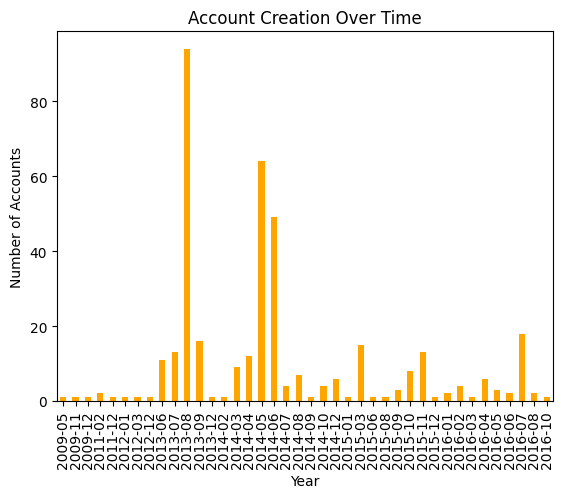

In [135]:
df_users["created_at"] = pd.to_datetime(df_users["created_at"])

df_users["created_at"].dt.to_period("M").value_counts().sort_index().plot(
    kind="bar", color="orange"
)
plt.title("Account Creation Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Accounts")
plt.savefig("figures/account_creation.png")
plt.show()

#### Potential bot accounts

In [136]:
df_users["engagement_rate"] = df_users["statuses_count"] / (
    df_users["followers_count"] + 1
)  # Avoid division by zero
most_active_low_engagement = df_users.sort_values(
    by="engagement_rate", ascending=False
).head(10)
print("Most Active Users with Low Engagement:")
most_active_low_engagement[
    ["screen_name", "statuses_count", "followers_count", "engagement_rate"]
].to_csv("figures/most_active_low_engagement.csv", index=False)
print(
    most_active_low_engagement[
        ["screen_name", "statuses_count", "followers_count", "engagement_rate"]
    ]
)

Most Active Users with Low Engagement:
       screen_name  statuses_count  followers_count  engagement_rate
5        darknally         22603.0             22.0       982.739130
362     BerlinBote          6804.0              8.0       756.000000
288        kelvsok           165.0              0.0       165.000000
325         anzgri         61735.0           1267.0        48.686909
348  internalmemer          3871.0             92.0        41.623656
340  MargarethKurz           250.0              6.0        35.714286
0      SCOTTGOHARD         31858.0           1053.0        30.225806
129          6Druz          2024.0             70.0        28.507042
289       nataturn           173.0              6.0        24.714286
147  Sergbriantsev          1280.0             51.0        24.615385


In [137]:
potential_bots = df_users[
    (df_users["followers_count"] < 100) & (df_users["statuses_count"] > 1000)
]
potential_bots.to_csv("figures/potential_bots.csv", index=False)
print(f"Potential Bots Found: {len(potential_bots)}")

Potential Bots Found: 22


In [138]:
G = nx.Graph()
for _, row in df_users.iterrows():
    G.add_node(
        row["id"], followers=row["followers_count"], friends=row["friends_count"]
    )

centrality = nx.degree_centrality(G)
top_central_users = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Central Users by Degree Centrality:")
top_central_users_df = pd.DataFrame(
    top_central_users, columns=["user_id", "centrality"]
).to_csv("figures/top_central_users.csv", index=False)
print(top_central_users)

Top Central Users by Degree Centrality:
[(100345056.0, 0.0), (247165706.0, 0.0), (249538861.0, 0.0), (449689677.0, 0.0), (471868887.0, 0.0), (1039581360.0, 0.0), (1510488662.0, 0.0), (1513801268.0, 0.0), (1517678892.0, 0.0), (1518857420.0, 0.0)]


#### User-hashtags

In [139]:
df_tweets = load_twitter_data(url)

Loaded 203451 tweets


50 top most reetweeted users, edges indicate a user has retweeted someone else

Nodes: 148, Edges: 578


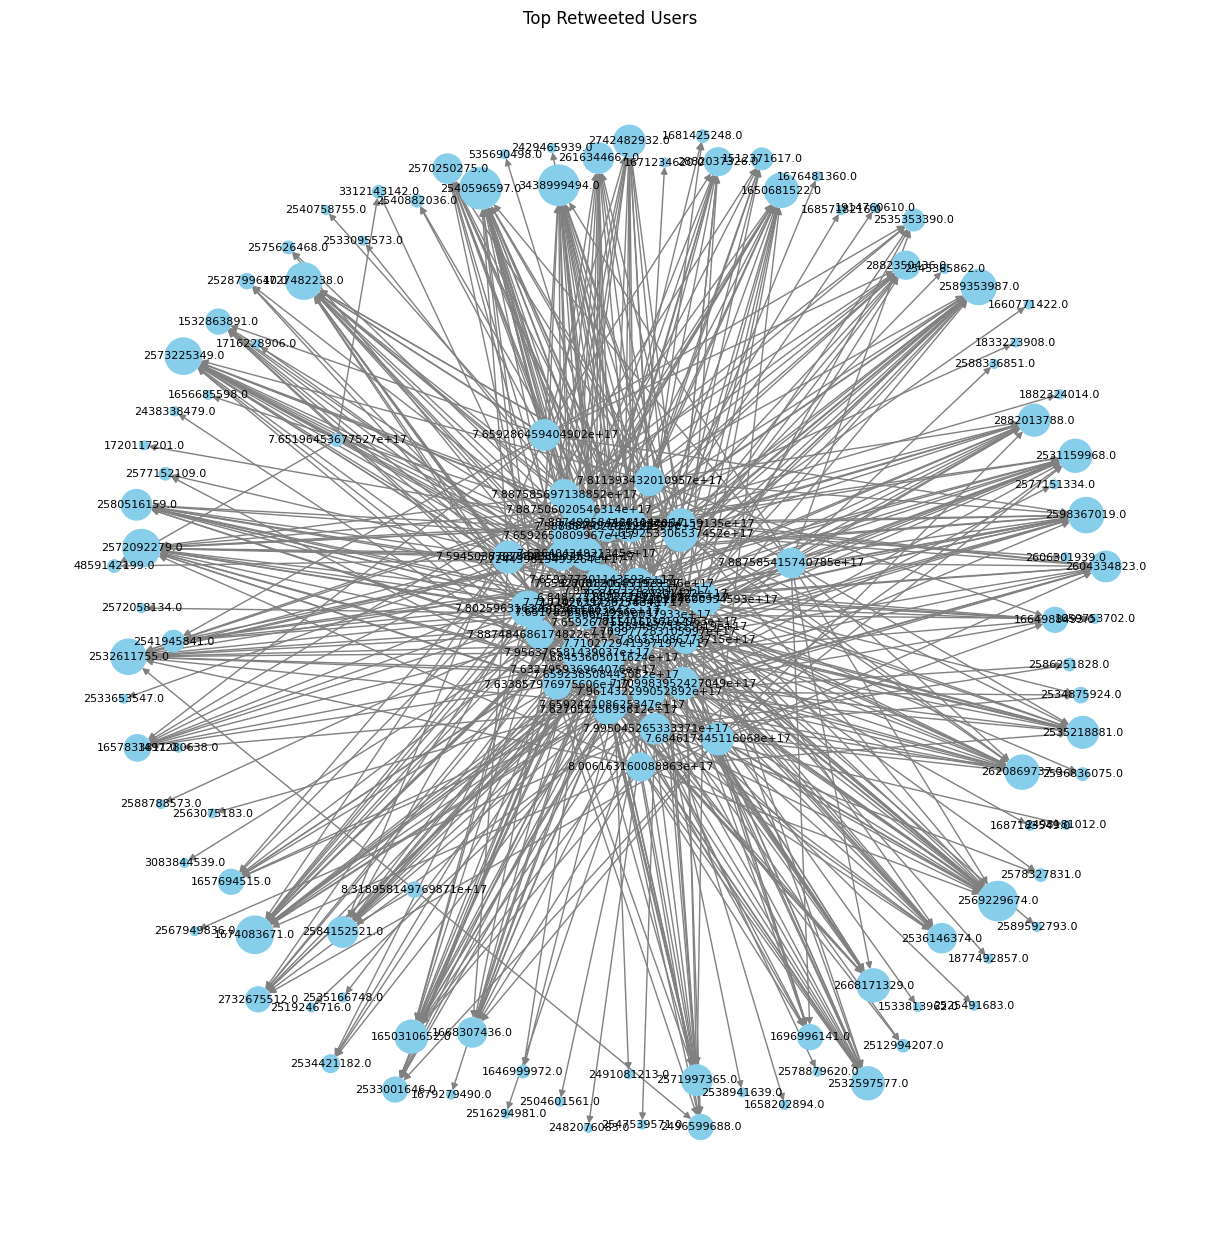

In [140]:
retweeted_counts = df_tweets["retweeted_status_id"].value_counts()
top_retweeted_users = retweeted_counts.head(50).index.tolist()

filtered_retweets = df_tweets[
    df_tweets["retweeted_status_id"].isin(top_retweeted_users)
]

G = nx.DiGraph()

for _, row in filtered_retweets.iterrows():
    original_user = row["retweeted_status_id"]
    retweeter = row["user_id"]
    G.add_edge(original_user, retweeter)

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
node_sizes = [G.degree(node) * 40 for node in G.nodes()]


plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.1)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=node_sizes,
    node_color="skyblue",
    font_size=8,
    font_color="black",
    edge_color="gray",
)
plt.title("Top Retweeted Users")
plt.savefig("figures/top_retweeted_users.png")
plt.show()

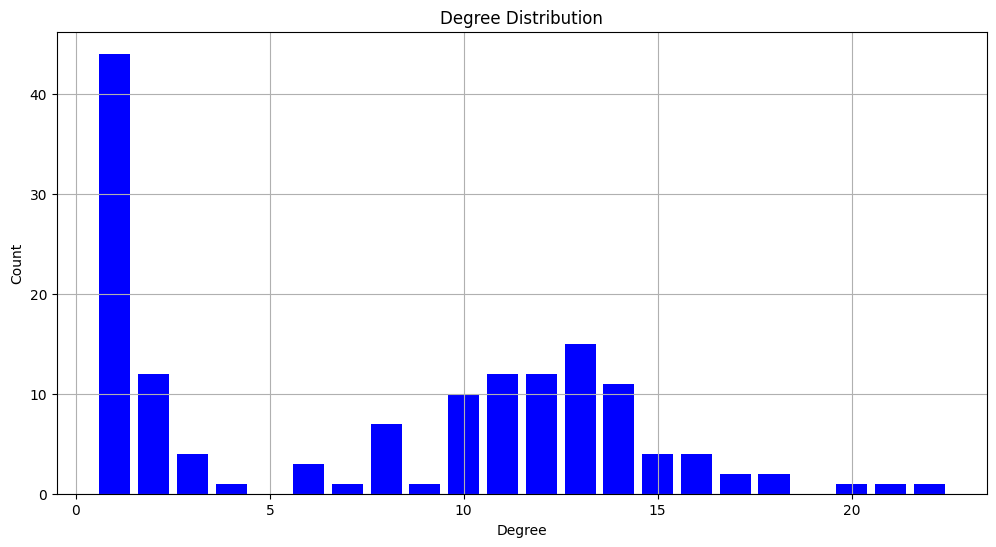

In [141]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = Counter(degree_sequence)
deg, cnt = zip(*degree_count.items())

plt.figure(figsize=(12, 6))
plt.bar(deg, cnt, width=0.80, color="b")

plt.title("Degree Distribution")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.grid(True)
plt.savefig("figures/top_reetweeted_users_degree_distribution.png")
plt.show()

Nodes: 542, Edges: 1025


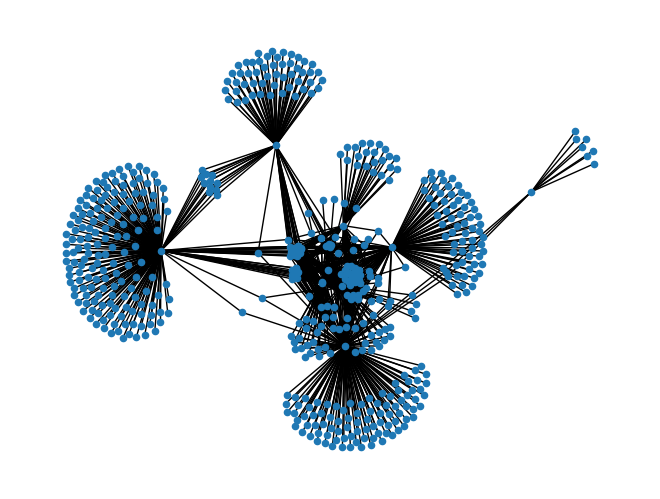

In [142]:
from collections import Counter

hashtags_flat = [tag for tags in df_tweets["hashtags"] if tags for tag in tags]
top_hashtags = [hashtag for hashtag, _ in Counter(hashtags_flat).most_common(10)]

filtered_tweets = df_tweets[
    df_tweets["hashtags"].apply(
        lambda tags: any(tag in top_hashtags for tag in tags) if tags else False
    )
]


B = nx.Graph()
for _, row in filtered_tweets.iterrows():
    user = row["user_id"]
    hashtags = row["hashtags"]
    for tag in hashtags:
        if tag in top_hashtags:
            B.add_edge(user, tag)

print(f"Nodes: {B.number_of_nodes()}, Edges: {B.number_of_edges()}")
nx.draw(B, with_labels=False, node_size=20, font_size=8)